<a href="https://colab.research.google.com/github/llaser00/Tests/blob/main/run_on_idc_data_fixing_pytorch_issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run AI segmentation on the TCGA-LIHC collection.

Be sure to run this in a runtime with an attached GPU


Querying and Download the CT scans is based on the [IDC  tutorial cookbook](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/cookbook.ipynb).

## Prerequisites
Please complete the prerequisites as described in this [documentation page](https://learn.canceridc.dev/introduction/getting-started-with-gcp).

Insert that project ID in the cell below.

In [ ]:
#@title Enter your Project ID and authenticate with GCP
# initialize this variable with your Google Cloud Project ID!
my_ProjectID = 'test-project-160126'

import os
os.environ["GCP_PROJECT_ID"] = my_ProjectID

from google.colab import auth
auth.authenticate_user()

import pandas as pd
import subprocess
from pathlib import Path
from tempfile import TemporaryDirectory
import shutil
from tqdm.auto import tqdm

Install the `s5cmd` tool for efficient manifest downloads

In [ ]:
%%shell
VERSION="s5cmd_2.2.2_Linux-64bit"
wget https://github.com/peak/s5cmd/releases/download/v2.2.2/${VERSION}.tar.gz
tar zxf ${VERSION}.tar.gz
mv s5cmd /usr/bin

--2026-02-03 09:15:17--  https://github.com/peak/s5cmd/releases/download/v2.2.2/s5cmd_2.2.2_Linux-64bit.tar.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/73909333/e095ae85-9acf-4dcc-b744-128b3311849c?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-02-03T10%3A02%3A41Z&rscd=attachment%3B+filename%3Ds5cmd_2.2.2_Linux-64bit.tar.gz&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-02-03T09%3A02%3A21Z&ske=2026-02-03T10%3A02%3A41Z&sks=b&skv=2018-11-09&sig=NH2Y5AwT1CahQcd81P6Ua0no1pbWBgHL5U3wl%2BbP3ZM%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc3MDExMDQxNywibmJmIjoxNzcwMTEwMTE3LCJwYXRoIjoicmVsZWFzZWFz

Install dcm2niix for dicom conversion. Use the prebuild version because it was jpeg support.

In [ ]:
%%shell
curl -fLO https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
unzip -o dcm2niix_lnx.zip -d /usr/bin

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  866k  100  866k    0     0  1480k      0 --:--:-- --:--:-- --:--:-- 15.5M
Archive:  dcm2niix_lnx.zip
  inflating: /usr/bin/dcm2niix       


We can build a download manifest. To reproduce our results, get a list of the SeriesInstanceUIDs from the `qa-results.csv` file. This csv is in the liver-ct.zip file at https://zenodo.org/record/8352041. Alternativly, we can get a copy directly from the github repo

In [ ]:
%%shell
wget https://github.com/bamf-health/aimi-liver-ct/raw/main/qa-results/qa-results.csv

--2026-02-03 09:15:18--  https://github.com/bamf-health/aimi-liver-ct/raw/main/qa-results/qa-results.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bamf-health/aimi-liver-ct/main/qa-results/qa-results.csv [following]
--2026-02-03 09:15:18--  https://raw.githubusercontent.com/bamf-health/aimi-liver-ct/main/qa-results/qa-results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30110 (29K) [text/plain]
Saving to: ‘qa-results.csv.3’

qa-results.csv.3    100%[===================>]  29.40K  --.-KB/s    in 0.002s  

2026-02-03 09:15:18 (17.2 MB/s) - ‘qa-results.csv.3’ saved [30110/30110]



In [ ]:
qa_df = pd.read_csv('qa-results.csv')
series_uids = qa_df.SeriesInstanceUID.tolist()

In [ ]:
# python API is the most flexible way to query IDC BigQuery metadata tables
!pip install google-cloud-bigquery
!pip install db-dtypes
import db_dtypes # Explicitly import db_dtypes
from google.cloud import bigquery
bq_client = bigquery.Client(my_ProjectID)

# The series_uids are already correctly formatted as single-quoted strings
# from the qa_df.SeriesInstanceUID.tolist() step, based on the current kernel state.
# Removing the line below to avoid double-quoting.
series_uids = [f"'{x}'" for x in series_uids]

selection_query =f"""
SELECT
  # Organize the files in-place right after downloading
  ANY_VALUE(CONCAT("cp s3",REGEXP_SUBSTR(gcs_url, "(://.*)/"),"/* ",collection_id,"/",PatientID,"/",StudyInstanceUID,"/",SeriesInstanceUID)) AS s5cmd_command
FROM
  `bigquery-public-data.idc_current.dicom_all`
WHERE
  SeriesInstanceUID IN ({','.join(series_uids)})
GROUP BY
  SeriesInstanceUID
"""

selection_result = bq_client.query(selection_query)
selection_df = selection_result.result().to_dataframe()

selection_df.to_csv("/content/s5cmd_gcp_manifest.txt", header=False, index=False)

/usr/local/lib/python3.12/dist-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Download manifest with the `s5cmd` tool.

In [ ]:
%%shell
# check if dicoms have already been downloaded
if test -n "$(find dcms -name '*.dcm' -print -quit)"
then
    echo "dicoms already downloaded"
else
  mkdir -p dcms
  cd dcms && s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run ../s5cmd_gcp_manifest.txt
  cd -
fi

Streaming output truncated to the last 5000 lines.
cp s3://idc-open-data/64f3d1f1-f5c1-4865-ba53-ec0dcd9b80be/8fe7abb6-e281-4294-981d-0741a2f2cda5.dcm tcga_lihc/TCGA-DD-A4NL/1.3.6.1.4.1.14519.5.2.1.3344.4008.295852698560353190326329207249/1.3.6.1.4.1.14519.5.2.1.3344.4008.174933394548192471772029827767/8fe7abb6-e281-4294-981d-0741a2f2cda5.dcm
cp s3://idc-open-data/8f5f85bb-53ad-40aa-818e-7a84ce7b0e04/8ecca396-50f7-49d6-8221-792793e2e041.dcm tcga_lihc/TCGA-DD-A4NL/1.3.6.1.4.1.14519.5.2.1.3344.4008.217381303091455644784847397746/1.3.6.1.4.1.14519.5.2.1.3344.4008.477051078981473110616142832395/8ecca396-50f7-49d6-8221-792793e2e041.dcm
cp s3://idc-open-data/f7a67d5f-0dc5-47eb-b9f2-88896c75e854/f3898a69-e1ce-43b5-a8d0-9f8f9a3fb4ba.dcm tcga_lihc/TCGA-DD-A1E9/1.3.6.1.4.1.14519.5.2.1.3344.4008.824746819228131664143570751388/1.3.6.1.4.1.14519.5.2.1.3344.4008.208949456379783541277979256617/f3898a69-e1ce-43b5-a8d0-9f8f9a3fb4ba.dcm
cp s3://idc-open-data/77a3443e-a326-4843-9c52-bc18da839728/9246e0ed

# Run model on TCGA-LIHC
You can run the model on the downloaded scans with the below code.

>If you want to run the model locally, this code is containerized in the project. Refer to the [readme](https://github.com/bamf-health/aimi-liver-ct/tree/main#running-inference) for instructions on running the container locally.

Install `nnunet` python package

In [ ]:
%%capture
!pip install nnunet

In [ ]:
# setup nnunet paths
os.environ["nnUNet_raw_data_base"] ="/nnunet_data/nnUNet_raw_data_base/"
os.environ["nnUNet_preprocessed"] ="/nnunet_data/nnUNet_preprocessed/"
os.environ["RESULTS_FOLDER"] ="/nnunet_data/nnUNet_trained_models/"


download model weights from zenodo

In [ ]:
%%shell
# check if weights exist before starting a large downloaded
if [ ! -f ${RESULTS_FOLDER}nnUNet/3d_fullres/Task773_Liver/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/model_final_checkpoint.model ]
then
    mkdir -p ${nnUNet_raw_data_base}
    mkdir -p ${nnUNet_preprocessed}
    mkdir -p ${RESULTS_FOLDER}nnUNet/
    echo "Downloading model weights"
    wget https://zenodo.org/record/8274976/files/Task773_Liver.zip
    unzip Task773_Liver.zip -d ${RESULTS_FOLDER}nnUNet/
else
    echo "model weights already downloaded"
fi

--2026-02-03 09:18:11--  https://zenodo.org/record/8274976/files/Task773_Liver.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.185.48.75, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/8274976/files/Task773_Liver.zip [following]
--2026-02-03 09:18:12--  https://zenodo.org/records/8274976/files/Task773_Liver.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1166314033 (1.1G) [application/octet-stream]
Saving to: ‘Task773_Liver.zip’

Task773_Liver.zip   100%[===================>]   1.09G  1.83MB/s    in 15m 32s 

2026-02-03 09:33:44 (1.19 MB/s) - ‘Task773_Liver.zip’ saved [1166314033/1166314033]

Archive:  Task773_Liver.zip
   creating: /nnunet_data/nnUNet_trained_models/nnUNet/3d_fullres/
   creating: /nnunet_data/nnUNet_trained_models/nnUNet/3d_fullres/Task773_Liver/
   creating: /nnunet_data/n

Install binaries for `itkimage2segimage` executable

In [ ]:
%%shell
# Install binaries for itkimage2segimage package
mkdir -p /app
PACKAGE_TAR="dcmqi-1.2.5-linux.tar.gz"
ITKIMAGE2SEGIMAGE_URL=https://github.com/QIICR/dcmqi/releases/download/v1.2.5/${PACKAGE_TAR}
wget ${ITKIMAGE2SEGIMAGE_URL} --no-check-certificate
tar -zxvf ${PACKAGE_TAR} -C /app
rm ${PACKAGE_TAR}

--2026-02-03 09:33:54--  https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/50675718/79d3ad95-9f0c-42a4-a1c5-bf5a63461894?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-02-03T10%3A28%3A32Z&rscd=attachment%3B+filename%3Ddcmqi-1.2.5-linux.tar.gz&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-02-03T09%3A27%3A56Z&ske=2026-02-03T10%3A28%3A32Z&sks=b&skv=2018-11-09&sig=w%2FgjfOu1znea3lxYOQLUzmF0TW5Lfb1NXxdib5i%2F%2BsM%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc3MDExMzAzNCwibmJmIjoxNzcwMTExMjM0LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJ

Run inference on scans.

First download  `run.py` and `ai-dicom-seg-meta.json` from the git repo

In [ ]:
%%shell
wget https://github.com/bamf-health/aimi-liver-ct/raw/main/container/app/src/run.py
wget https://github.com/bamf-health/aimi-liver-ct/raw/main/container/app/dcm-meta/ai-dicom-seg-meta.json

--2026-02-03 09:33:55--  https://github.com/bamf-health/aimi-liver-ct/raw/main/container/app/src/run.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bamf-health/aimi-liver-ct/main/container/app/src/run.py [following]
--2026-02-03 09:33:56--  https://raw.githubusercontent.com/bamf-health/aimi-liver-ct/main/container/app/src/run.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7429 (7.3K) [text/plain]
Saving to: ‘run.py’

run.py              100%[===================>]   7.25K  --.-KB/s    in 0s      

2026-02-03 09:33:56 (122 MB/s) - ‘run.py’ saved [7429/7429]

--2026-02-03 09:33:56--  https:

Then run model on all downloaded dicom series

In [ ]:
!rm -rf preds

In [ ]:
#from run import main_dicom

In [ ]:
#dcm_dir = Path('dcms')
#seg_dir = Path('preds')
#seg_meta = Path('ai-dicom-seg-meta.json')

In [ ]:
import torch
import os
from nnunet.inference.predict_simple import main as nnunet_main
import sys

# 1. Disable the security check in the current process
# This is the "Magic Sauce" for PyTorch 2.6+
import torch.serialization
torch.serialization.add_safe_globals(['numpy.core.multiarray.scalar', 'numpy.dtype', 'numpy._core.multiarray.scalar'])

# 2. Set the environment variable for the internal logic
os.environ["RESULTS_FOLDER"] = "/nnunet_data/nnUNet_trained_models/"
os.environ["TORCH_FORCE_WEIGHTS_ONLY_LOAD"] = "0"

# 3. Manually simulate the command line arguments
sys.argv = [
    "nnUNet_predict",
    "-i", "/content/nnunet_input",
    "-o", "/content/preds",
    "-t", "773",
    "-m", "3d_fullres",
    "-f", "0"
]

# 4. Run the function directly in Python (so it inherits our 'add_safe_globals')
print("Starting prediction via Python entry point...")
nnunet_main()



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Starting prediction via Python entry point...
using model stored in  /nnunet_data/nnUNet_trained_models/nnUNet/3d_fullres/Task773_Liver/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 1 unique case ids, here are some examples: ['test_scan']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 1
number of cases that still need to be predicted: 1
emptying cuda cache
loading parameters for folds, [0]
using the following model files:  ['/nnunet_data/nnUNet_trained_models/nnUNet/3d_fullres/Task773_Liver/nnUNetTrainerV2__nnUNe

/usr/local/lib/python3.12/dist-packages/nnunet/training/network_training/network_trainer.py:404: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.amp_grad_scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/nnunet/network_architecture/neural_network.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with context():


done
prediction done
inference done. Now waiting for the segmentation export to finish...
force_separate_z: None interpolation order: 1
separate z: True lowres axis [0]
separate z, order in z is 0 order inplane is 1
WARNING! Cannot run postprocessing because the postprocessing file is missing. Make sure to run consolidate_folds in the output folder of the model first!
The folder you need to run this in is /nnunet_data/nnUNet_trained_models/nnUNet/3d_fullres/Task773_Liver/nnUNetTrainerV2__nnUNetPlansv2.1


In [ ]:
import os
output_path = "/content/preds/test_scan.nii.gz"

if os.path.exists(output_path):
    print(f"✅ Success! Prediction found at {output_path}")
    print(f"File size: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")
else:
    print("❌ The file wasn't saved. We might need to check the output folder permissions.")

✅ Success! Prediction found at /content/preds/test_scan.nii.gz
File size: 0.05 MB


In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# 1. Load data
img_nifti = nib.load('/content/nnunet_input/test_scan_0000.nii.gz')
img = img_nifti.get_fdata()
mask = nib.load('/content/preds/test_scan.nii.gz').get_fdata()

# 2. Windowing the CT (Level: 40, Width: 400 is standard for Liver)
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed = np.clip(image, img_min, img_max)
    return windowed

img_windowed = window_image(img, 40, 400)

# 3. Find a slice that actually has liver in it
# Instead of just the middle, find where the mask has the most pixels
slice_sums = np.sum(mask, axis=(0, 1))
slice_idx = np.argmax(slice_sums)

if slice_sums[slice_idx] == 0:
    print("Warning: No liver detected in any slice. Showing middle slice instead.")
    slice_idx = img.shape[2] // 2

# 4. Plot
plt.figure(figsize=(15, 7))

# Original Windowed CT
plt.subplot(1, 2, 1)
plt.imshow(img_windowed[:, :, slice_idx].T, cmap='gray', origin='lower')
plt.title(f"CT Slice {slice_idx} (Windowed)")
plt.axis('off')

# CT + Mask Overlay
plt.subplot(1, 2, 2)
plt.imshow(img_windowed[:, :, slice_idx].T, cmap='gray', origin='lower')
# Mask values are usually 1 for liver, 2 for tumors.
# We use a masked array so 0 (background) is transparent.
masked_liver = np.ma.masked_where(mask <= 0, mask)
plt.imshow(masked_liver[:, :, slice_idx].T, cmap='autumn', alpha=0.5, origin='lower')
plt.title("AI Liver Segmentation Overlay")
plt.axis('off')

plt.show()

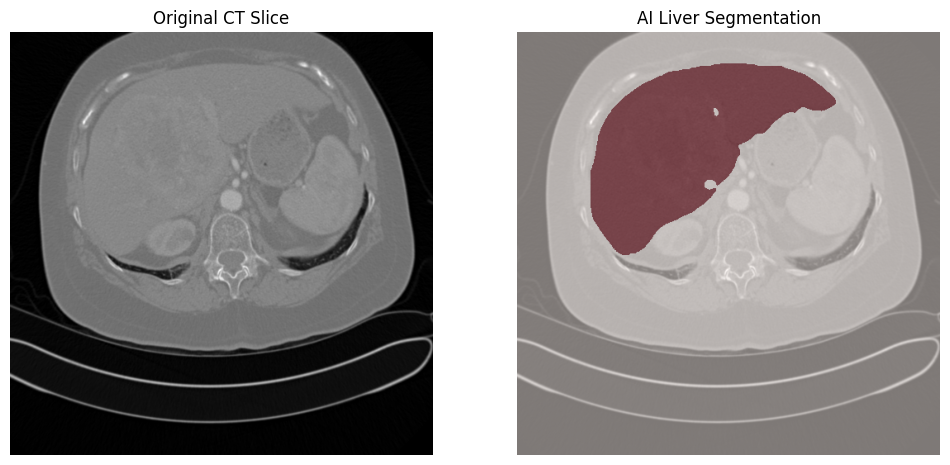

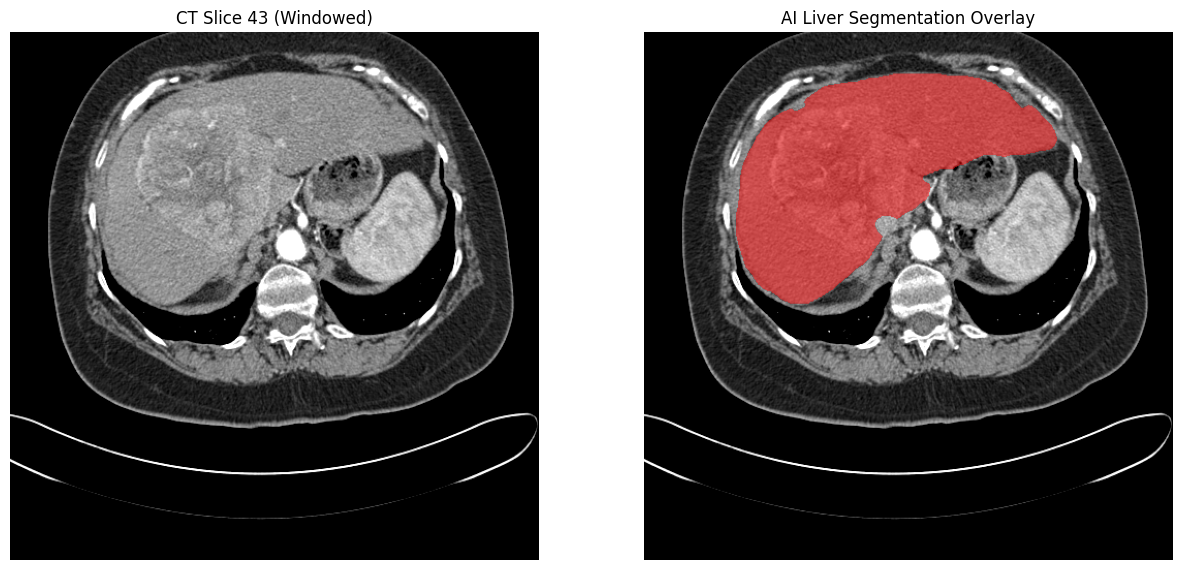

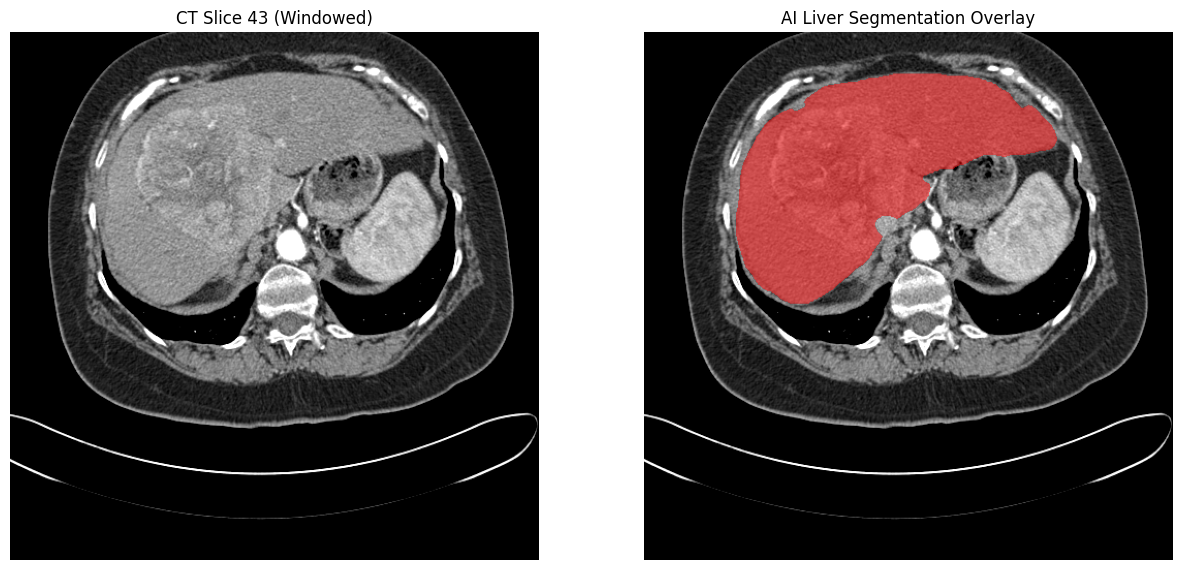

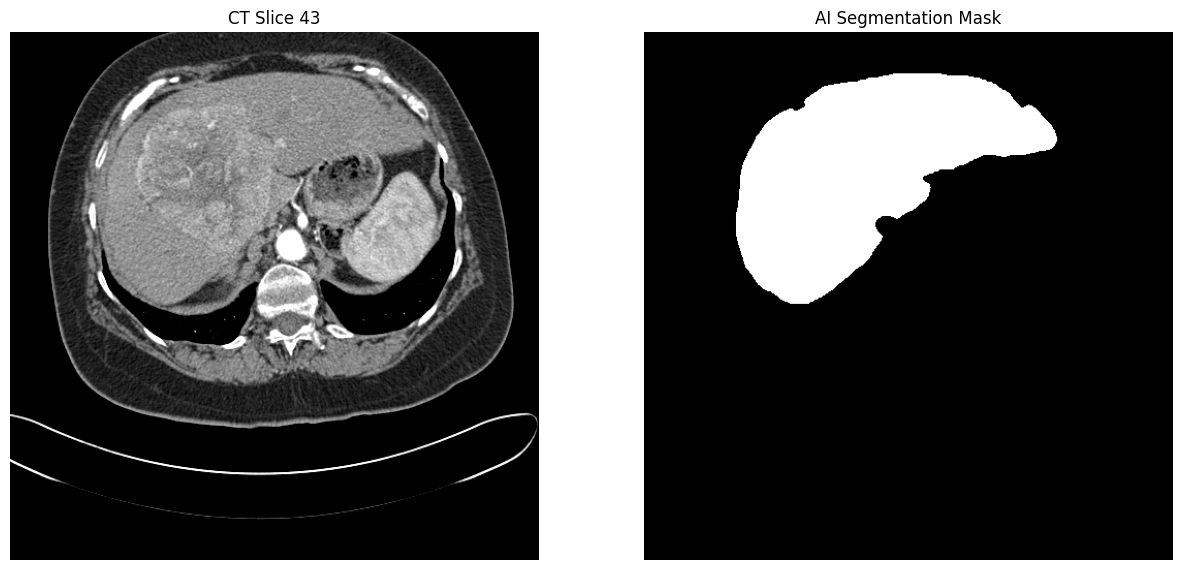

Slice index shown: 43
Max value in CT slice: 240.0
Max value in Mask slice: 1.0


In [ ]:
%matplotlib inline
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the data
img_nifti = nib.load('/content/nnunet_input/test_scan_0000.nii.gz')
mask_nifti = nib.load('/content/preds/test_scan.nii.gz')

img = img_nifti.get_fdata()
mask = mask_nifti.get_fdata()

# 2. Pick a slice that we KNOW has data (finding the slice with max mask pixels)
z_slice = np.argmax(np.sum(mask, axis=(0, 1)))

# 3. Simple Windowing (Soft Tissue Window)
# CT values: -160 to 240 is a good range for the liver
img_slice = img[:, :, z_slice].T
img_slice = np.clip(img_slice, -160, 240)

# 4. Create the plot
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Left: The Original Scan
ax[0].imshow(img_slice, cmap='gray', origin='lower')
ax[0].set_title(f"CT Slice {z_slice}")
ax[0].axis('off')

# Right: The Binary Mask (Should be Black and White)
ax[1].imshow(mask[:, :, z_slice].T, cmap='gray', origin='lower')
ax[1].set_title("AI Segmentation Mask")
ax[1].axis('off')

plt.show()

# Data Debug Check
print(f"Slice index shown: {z_slice}")
print(f"Max value in CT slice: {np.max(img_slice)}")
print(f"Max value in Mask slice: {np.max(mask[:, :, z_slice])}")

In [ ]:
import nibabel as nib
import numpy as np

mask_data = nib.load('/content/preds/test_scan.nii.gz').get_fdata()
print(f"Unique values in mask: {np.unique(mask_data)}")
print(f"Total liver voxels found: {np.sum(mask_data > 0)}")

Unique values in mask: [0. 1.]
Total liver voxels found: 1133310


Download segmentations

In [ ]:
from google.colab import files
import os

# Zip the result so it's a single download
!zip -j liver_prediction.zip /content/preds/test_scan.nii.gz /content/nnunet_input/test_scan_0000.nii.gz

if os.path.exists("liver_prediction.zip"):
    files.download("liver_prediction.zip")
    print("Download started! Open these in ITK-SNAP or 3D Slicer.")
else:
    print("Zip file failed to create. Check if /content/preds/test_scan.nii.gz exists.")

  adding: test_scan.nii.gz (deflated 44%)
  adding: test_scan_0000.nii.gz (deflated 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started! Open these in ITK-SNAP or 3D Slicer.


In [ ]:
%%shell
zip -r preds.zip . -i preds

	zip warning: zip file empty


In [ ]:
from google.colab import files
files.download('preds.zip')